In [132]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
nltk.download('stopwords')
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from statistics import mean 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pvali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
# Functions to clean skills data and make a vocabulary for skills vectorization
common_placeholders = [
    'see job description', 'n/a', 'not applicable', 'none', 'no skills required', 
    'please see job description', 'refer to job description'
]

import re
import pandas as pd

def text_scrubber(values):
    result = []
    for string in values:
        if pd.isna(string):
            result.append('')
        else:
            # If the string is a list-like string, convert it to an actual list
            if string.startswith("[") and string.endswith("]"):
                # Convert string to list by stripping brackets and splitting by comma
                temp_list = string[1:-1].split(',')
                # Clean and strip each skill in the list
                temp_list = [skill.strip(" '") for skill in temp_list]
                # Join the list back into a comma-separated string
                temp = ', '.join(temp_list)
            else:
                # Convert to lowercase
                temp = string.lower()
                # Remove content in parentheses, replace HTML entities and special characters
                temp = re.sub(r'\(.*\)|&#39;|\x92', '', temp)
                temp = re.sub(r' &amp; |&amp;|\x95|:|;|&|\.|/| and |,|\+|/', ',', temp)
                # Normalize white spaces
                temp = re.sub(r'\s+', ' ', temp).strip()
                # Split the skills into a list and remove empty entries
                temp_list = [skill.strip() for skill in temp.split(',') if skill.strip()]
                # Rejoin the cleaned skills into a string separated by commas
                temp = ', '.join(temp_list)
            result.append(temp)
    return result


def tokenizer(df):
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'nice' 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily', 'next','magic','world','interview',
             'services', 'job', 'good','using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39','see below','yes','null'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():        
        # Split on commas
        array = row['skills']
        array=str(array)
        array=array.split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    result_df['skills'] = values
    print(result_df)
    return result_df

#df = pd.read_csv("../../data/dice-shortened.csv")
df = pd.read_csv("../karim/jobs_to_upload.csv")
print(df)


                                  uid  \
0    ae0b5919e2444b0b90e1ce9be0b83e31   
1    d4d9c89e9dcb43e4a1a27a68bec7efc9   
2    d8579f3ca2604c518d2277ffb4fdcdbe   
3    eaa23c84a06149169b598e795871661c   
4    4b02e451c105424faa068a3c4ee3c79b   
..                                ...   
107  cc70d8e00eca4ccca1fa7eb4b28920a0   
108  c2c18cfdf265403bba5951eb151bade4   
109  c43c474af99d48a49d839f8ad5ab3c11   
110  47c3e08566f14195bd8519fded06363a   
111  a45a8df013c246329aa431c5f8a4bb91   

                                                 title  \
0                                   software developer   
1                                    software engineer   
2                                        Java Engineer   
3                     Technical Lead Software Engineer   
4                         Full-Stack Developer (React)   
..                                                 ...   
107                               Software Engineer II   
108                         Web Application

In [134]:
df['skills'] = text_scrubber(df['skills'])
print(df['skills'])
df['skills'].to_csv("skills_test.csv", index=False)

0                                                       
1                                                       
2                                           java, spring
3                                                      s
4      java, aws, sql, python, r, kotlin, javascript,...
                             ...                        
107                              inform, sql, ruby, play
108    angular, laravel, sql, css, node.js, vue.js, j...
109                                                     
110                                                     
111                                                    s
Name: skills, Length: 112, dtype: object


In [135]:
df.to_csv("df.csv", index=False)
test_df = tokenizer(df)
test_df.to_csv("test_df.csv", index=False)

         skills
0          java
1        spring
2          java
3           aws
4           sql
..          ...
600      vue.js
601  javascript
602         php
603        html
604       react

[605 rows x 1 columns]


In [136]:
voc = test_df['skills'].unique()
print(voc)

['java' 'spring' 'aws' 'sql' 'python' 'r' 'kotlin' 'javascript' 'react'
 'agile' 'typescript' 'couchdb' '.net' 'angular' 'azure' 'c' 'html' 'css'
 'android' 'cordova' 'node.js' 'ios' 'swift' 'sqlite' 'oracle' 'clean'
 'xslt' 'ajax' 'spark' 'hive' 'postgresql' 'flink' 'wordpress' 'vue.js'
 'c++' 'play' 'scala' 'serverless' 'go' 'linux' 'apex' 'bash' 'shell'
 'assembly' 'catalyst' 'rust' 'redis' 'opa' 'mainframe' 'struts' 'ml'
 'pytorch' 'lift' 'flex' 'firebase' 'sharepoint' 'php' 'ruby' 'mysql'
 'abap' 'designer' 'powershell' 'cassandra' 'self' 'express' 'coldfusion'
 'asp' 'cuba' 'flask' 'django' 'salesforce' 'tensorflow' 'watson' 'lua'
 'laravel' 'inform']


In [137]:
import pandas as pd

# Read the CSV file
#df = pd.read_csv("../../data/dice-shortened.csv")
df = pd.read_csv("../karim/jobs_to_upload.csv")

# Define a function to clean the text in each job description
def clean_text(text):
    cleaned_text = text.replace("&nbsp;", " ").replace("\x92", " ").replace("\x95", " ").replace('&amp;', " ") \
        .replace('*', " ").replace(".", " ").replace("co&#39;s", "").replace("\xae&quot;", "") \
        .replace("&#39;s", "").replace("&quot;", "").replace("?", "").replace("&#39;s", "") \
        .replace("@", "").replace("\x96", "")
    return cleaned_text

# Apply the clean_text function to each element in the 'jobdescription' column
df['desc'] = df['desc'].apply(clean_text)
print(df['desc'])
df['desc'].to_csv("jobdesc_test.csv", index=False)

0        education: bachelor's degree experience: 7 m...
1        education: college, cegep or other non-unive...
2      java engineer : 10+ years : mississauga, ontar...
3          location address:   100 queens quay east, ...
4         life at capgemini  capgemini supports all a...
                             ...                        
107     hi, future homie!  as a homie, you'll be part...
108     tv2 consulting is seeking an experienced and ...
109      education: bachelor's degree experience: 2 y...
110      education: college/cegep experience: 1 year ...
111      about the role:     included health is build...
Name: desc, Length: 112, dtype: object


In [138]:
#min_df ignores terms that are in more than 20% of documents
mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily','services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements','summary','Job Role','Position']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2, max_features=10000, stop_words=list(text.ENGLISH_STOP_WORDS.union(list(mine))), decode_error='ignore', vocabulary=None, binary=False)

In [139]:

df['desc_new']=df['desc']+df['title']
df.to_csv("desc_new.csv", index=False)
description_matrix2 = vec.fit_transform(df['desc_new'].values.astype('U'))
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names_out()

In [140]:
description_matrix2.to_csv("description_matrix.csv", index=False)

In [143]:
#uses only vocab set made above for vectorization
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
df['skills_new']=df['skills']
skills_matrix2 = vec2.fit_transform(df['skills_new'].values.astype('U'))
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names_out()

In [144]:
skills_matrix2.to_csv("skills_matrix.csv", index=False)

In [145]:
jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)
jobtitle_matrix

,java,spring,aws,sql,python,r,kotlin,javascript,react,agile,...,yoe linux,yoe yoe,york,york application,young,young company,youtube,zone,zoom,zoom description
0,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.630478,0.776207,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.363863,0.000000,0.363863,0.292107,0.3527,0.0,0.52914,0.315057,0.382406,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.000000,0.000000,0.000000,0.257131,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,0.000000,0.000000,0.000000,0.230048,0.0000,0.0,0.00000,0.248122,0.301162,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
# Run PCA to reduce number of features
pca = PCA(n_components=112, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)
print(comps)

[[-6.02518387e-02 -2.16666109e-01 -3.66295009e-02 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]
 [-8.56487127e-02 -1.46662661e-01 -4.94536556e-02 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]
 [-3.37947408e-01 -7.03124135e-02  4.03548351e-01 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]
 ...
 [-3.30940830e-02 -2.39403479e-01 -3.09826143e-02 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]
 [-2.46943354e-02 -2.48431795e-01 -2.30193720e-02 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]
 [-1.51973153e-01 -1.29237492e-01 -9.38661997e-02 ...  3.56346841e-17
   1.58656801e-17  1.75166654e-18]]


In [208]:
# Put the components into a dataframe
comps = pd.DataFrame(comps)

In [209]:
print(comps)

          0         1         2         3         4         5         6    \
0   -0.060252 -0.216666 -0.036630  0.279968  0.078906  0.035646 -0.144584   
1   -0.085649 -0.146663 -0.049454  0.187127  0.081210  0.013945 -0.120270   
2   -0.337947 -0.070312  0.403548 -0.263421 -0.273355 -0.327042 -0.413929   
3   -0.131510 -0.103847 -0.086272  0.116447  0.070405 -0.040321 -0.094637   
4   -0.009560  0.021043  0.237389 -0.133022 -0.576651 -0.223023  0.741120   
..        ...       ...       ...       ...       ...       ...       ...   
107 -0.180900 -0.005590 -0.146896  0.095010  0.025353  0.112939 -0.062019   
108  0.490159 -0.175275  0.005912 -0.002841 -0.165073  0.013658 -0.039205   
109 -0.033094 -0.239403 -0.030983  0.298159  0.085462  0.052854 -0.146752   
110 -0.024694 -0.248432 -0.023019  0.313176  0.080688  0.058062 -0.146966   
111 -0.151973 -0.129237 -0.093866  0.120072  0.149411 -0.053118 -0.079593   

          7         8         9    ...       102       103           104  \

In [210]:
cltr = AgglomerativeClustering(n_clusters=10)
cltr.fit(comps)
df['cluster_no'] = cltr.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score3=lr.score(X_test, y_test)
print(score3)

0.8928571428571429


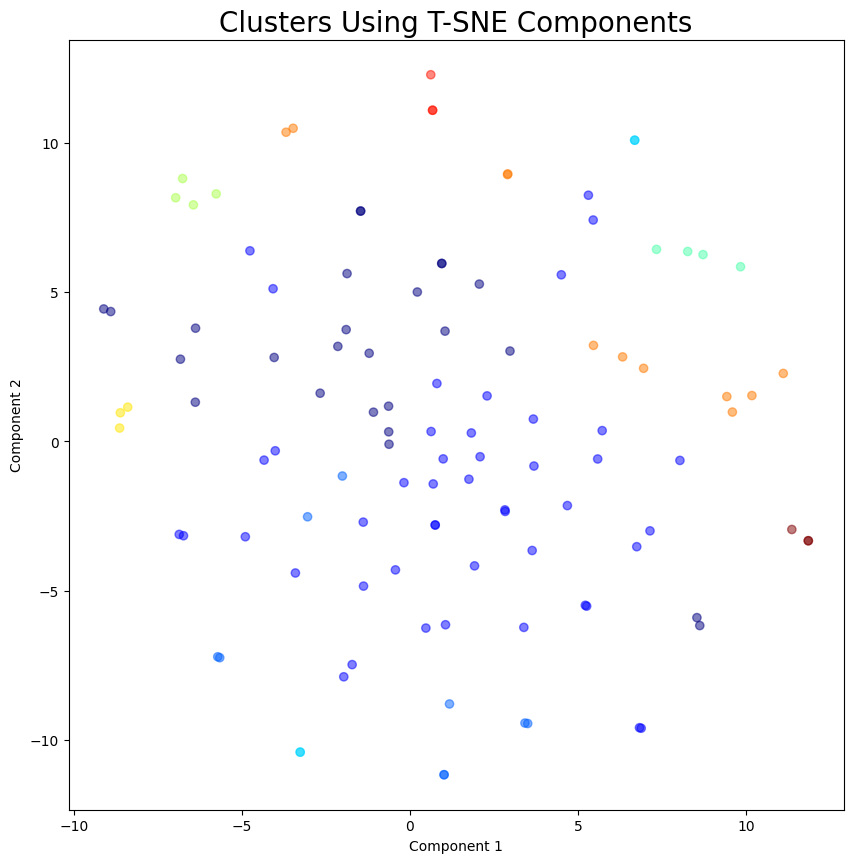

In [211]:
# Look at clusters

from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

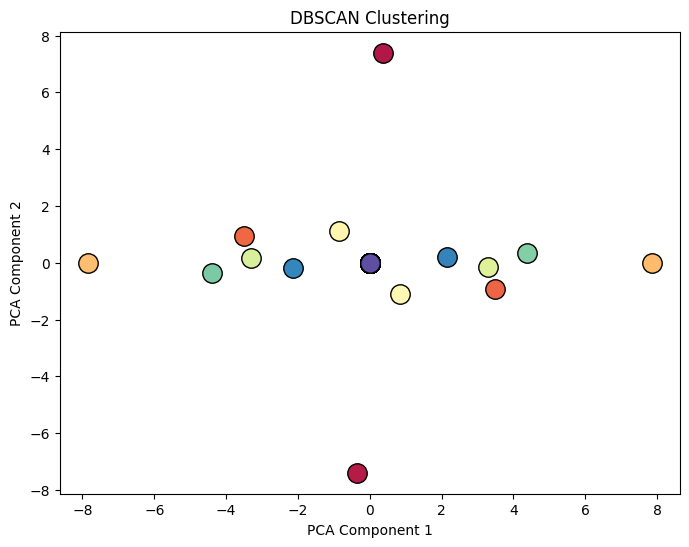

In [198]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'data' is your DataFrame with the features you want to cluster

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(comps))


# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=1)  # eps and min_samples need to be chosen appropriately
clusters = dbscan.fit_predict(data_scaled)

# Perform PCA for dimensionality reduction for visualization purposes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Create a scatter plot
plt.figure(figsize=(8, 6))
unique_labels = set(clusters)  # The unique labels of clusters from DBSCAN
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise (outliers).
        col = [0, 0, 0, 1]

    class_member_mask = (clusters == k)

    xy = data_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [212]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

In [213]:
print(comps)

                 0         1         2         3         4         5    \
cluster_no                                                               
0          -0.060252 -0.216666 -0.036630  0.279968  0.078906  0.035646   
1          -0.085649 -0.146663 -0.049454  0.187127  0.081210  0.013945   
7          -0.337947 -0.070312  0.403548 -0.263421 -0.273355 -0.327042   
1          -0.131510 -0.103847 -0.086272  0.116447  0.070405 -0.040321   
8          -0.009560  0.021043  0.237389 -0.133022 -0.576651 -0.223023   
...              ...       ...       ...       ...       ...       ...   
1          -0.180900 -0.005590 -0.146896  0.095010  0.025353  0.112939   
0           0.490159 -0.175275  0.005912 -0.002841 -0.165073  0.013658   
0          -0.033094 -0.239403 -0.030983  0.298159  0.085462  0.052854   
0          -0.024694 -0.248432 -0.023019  0.313176  0.080688  0.058062   
1          -0.151973 -0.129237 -0.093866  0.120072  0.149411 -0.053118   

                 6         7         

In [219]:
resume_text = '''jesus.brown3255@gmail.com SUMMARY:I am  a passion for using data to make faster and betterdecisions that leads to improved customer experiences and increased productivity. My combination oftechnical and business experience provides a unique skill-set to be able to work cross-functionally toachieve these results.SKILLSTECHNICAL:Java, Python (Pandas, Scikit-Learn, NumPy, Seaborn), Data Analytics , Big Data (AWS, Hadoop, Spark), Tableau,Advanced Microsoft Excel (Power BI, Macros, etc.) ·Student- DataScience·Oct2016 - Learned the skills to become a data professional including Python 'java', 'aws', 'sql', 'python', 'r', 'kotlin', 'javascript', 'react', 'd'
'''

In [217]:
def give_suggestions(resume_text):
    matches=dict()
    # Vectorize user's skills and job descriptions
    desc = pd.DataFrame(vec.transform([resume_text]).todense())
    desc.columns = vec.get_feature_names_out()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names_out()
    mat = pd.concat([skillz, desc], axis=1)
    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(mat))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print ('CLUSTER NUMBER', cluster, '\n\n')

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from df to associate cosine similarity scores with jobs
    samp_for_cluster = df[df['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(samp_for_cluster['title'])
    cos_sim.columns = ['score']
    
    # Print the top ten suggested jobs for the user's cluster
    top_cos_sim = cos_sim.sort_values('score', ascending=False)[:10]
    print ('Top ten suggested for your cluster', '\n', top_cos_sim, '\n\n')
    
   # print('Accuracy',)

    # Print the top five suggested jobs for each cluster
    mat = mat.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        samp_for_cluster = df[df['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(df, how='left', left_index=True, right_index=True)
        print ('---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n')
        # Vectorize to find skills needed for each job title
       
        for job in merged_top_5.index:
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.loc[job]['desc'] + merged_top_5.loc[job]['skills']]).todense())
            job_skills.columns = vec2.get_feature_names_out()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            mat.columns = ['score']
            mat = mat[mat['score'] != 0]
            needed_skills = []
            scorey = []
            for i in job_skills.index:
                if i not in mat.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.loc[i][0])
            top_skills = pd.DataFrame(list(zip(needed_skills, scorey)), columns=['Skills', 'Importance'])
            print('To become a/an', job,',', '\n', 'these are the top ten skills you need:', '\n')
            print(top_skills[:5], '\n')
    return top_cos_sim

In [113]:
resume_text=input("Enter your skills. These are programming languages, frameworks,platforms or databases that you have experience with")

In [229]:
#resume_text = ''' typescript, s, css, express, r, node.js, javascript, html, react '''
#resume_text = '''aws, s, .net, angular, sql, css, azure, javascript, c, agile, html '''
resume_text = ''' java, spring '''

In [230]:
cos_sim_result=give_suggestions(resume_text)

CLUSTER NUMBER 7 


Top ten suggested for your cluster 
                                                       score
title                                                      
Java Engineer                                      0.805282
Cloud Engineer                                     0.614196
Software Engineer                                  0.404386
Automation Test Engineer, Scotiabank               0.381846
Senior Java Developer                              0.348503
Senior Java Engineer                               0.330802
RQ06789 - Software Developer - SQL (Contract)      0.318128
RQ06735 - Software Developer - Jave EE (Contract)  0.238809
RQ06519 - Software Developer - Java EE (Contract)  0.212324
W0177 Senior Software Developer                    0.197786 


---------Top five suggested in cluster 0 ---------
         score
45   0.020866
30   0.010453
0    0.009801
109  0.008260
110  0.008069 


To become a/an 45 , 
 these are the top ten skills you need: 

    Skills  Import

In [134]:
import scipy.sparse as sp
from typing import List

def _single_list_similarity(predicted: list, feature_df: pd.DataFrame, u: int) -> float:
    # exception predicted list empty
    if not(predicted):
        raise Exception('Predicted list is empty, index: {0}'.format(u))

    #get features for all recommended items
    print(predicted)
    feature_df_reset = feature_df.set_index('jobtitle')
    print(feature_df_reset)
    recs_content = feature_df_reset.concat[predicted]
    #recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted: List[list], feature_df: pd.DataFrame) -> float:
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    print(predicted)
    ils = [_single_list_similarity(predicted[u], feature_df, u) for u in Users]
    return np.mean(ils)

top_10_recommendations=cos_sim_result.sort_values('score', ascending=False)[:10]
top_10_list = top_10_recommendations.reset_index().to_records(index=False).tolist()
first_elements = [item[0] for item in top_10_list]
feature_df = df[['jobtitle','jobdescription']]
intra_list_similarity(first_elements, feature_df)

['Python Developer', 'Senior Python Developer', 'SW test Python c/c++', 'Software Developer (3-5 years experience)', 'JavaScript Developer - React.JS', 'Python Developer for FinTech start up', 'Senior Python Developer', 'Front End Engineer - React- RELO to NYC!', 'Java/Python /c++Developers', 'c/c++ Python Mathematics']
Python Developer
                                                                                       jobdescription
jobtitle                                                                                             
AUTOMATION TEST ENGINEER                            Looking for Selenium engineers   must have sol...
Information Security Engineer                       The University of Chicago has a rapidly growin...
Business Solutions Architect                        GalaxE SolutionsEvery day, our solutions affec...
Java Developer (mid level)- FT- GREAT culture, ...  Java DeveloperFull-time/direct-hireBolingbrook...
DevOps Engineer                                  

AttributeError: 'DataFrame' object has no attribute 'concat'